# Evaluation of Simulation Models

This notebook studies various properties of the simulation models used in `covid19 outbreak simulator`.

In [3]:
from matplotlib import pyplot
import numpy as np
import pandas as pd

from argparse import Namespace
from covid19_outbreak_simulator.model import Model, Params
from covid19_outbreak_simulator.population import Individual

params = Params(
    Namespace(
        interval=1/24,
        popsize=['64'],
        infectors=[],
        symptomatic_r0=None,
        asymptomatic_r0=None,
        incubation_period=None,
        susceptibility=None,
        prop_asym_carriers=None,
        symptomatic_transmissibility_model = ['piecewise', 0.2, 0.7, 7, 9],
        asymptomatic_transmissibility_model = ['piecewise', 0.2, 0.4, 5, 7],
    )
)
model = Model(params)

## Distribution of asymptomatic carriers

In [49]:
avg_asym_carriers = 0
N = 1000
for i in range(N):
    model.draw_prop_asym_carriers()
    avg_asym_carriers += sum([model.draw_is_asymptomatic() for i in range(1000)])/1000

avg_asym_carriers /= N

print(f'Average asymptomatic carriers is {avg_asym_carriers * 100:.2f}%')
    

Average asymptomatic carriers is 24.59%


## Distribution of incubation period

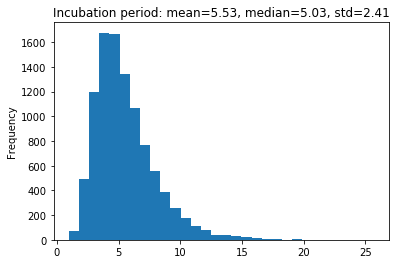

In [50]:
model.params.set('prop_asym_carriers', 'loc', 0)
model.params.set('prop_asym_carriers', 'scale', 0)

ips = pd.Series([model.draw_random_incubation_period() for x in range(10000)])

ips.plot(kind='hist', bins=30, 
         title=f'Incubation period: mean={ips.mean():.2f}, median={ips.median():.2f}, std={ips.std():.2f}')

## Distribution of production number

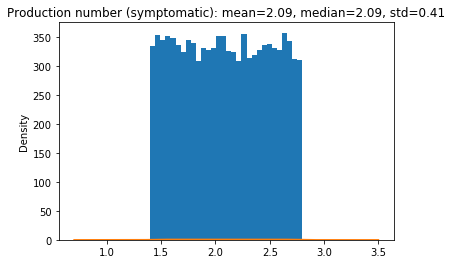

In [10]:
# thoretical distribution

sr0 = pd.Series([model.draw_random_r0(symptomatic=True) for x in range(10000)])
sr0.plot.hist( bins=30,
         title=f'Production number (symptomatic): mean={sr0.mean():.2f}, median={sr0.median():.2f}, std={sr0.std():.2f}')
sr0.plot.density()

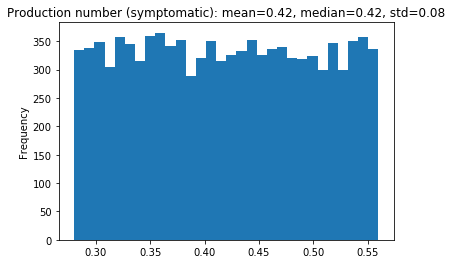

In [7]:

asr0 = pd.Series([model.draw_random_r0(symptomatic=False) for x in range(10000)])
asr0.plot.hist( bins=30,
         title=f'Production number (symptomatic): mean={asr0.mean():.2f}, median={asr0.median():.2f}, std={asr0.std():.2f}')


## Observed production number

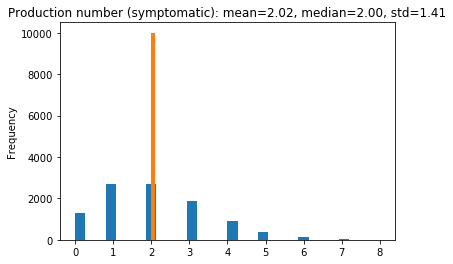

In [32]:
import os

model.params.set('prop_asym_carriers', 'loc', 0)
model.params.set('prop_asym_carriers', 'scale', 0)

infections = []
r0 = []
with open(os.devnull, 'w') as logger:
    logger.id = 1
    model.draw_prop_asym_carriers()
    model.params.set('symptomatic_r0', 'low', 2)
    model.params.set('symptomatic_r0', 'high', 2)
    for i in range(10000):
        ind = Individual(id='0', susceptibility=1, model=model, logger=logger)
        evts = ind.symptomatic_infect(time=0, by=None,
                                     handle_symptomatic=['keep'])
        r0.append(ind.r0)
        # print(', '.join(x.action.name for x in evts))
        infect_evts = [evt for evt in evts if evt.action.name == 'INFECTION']
        infections.append(len(infect_evts))

ifn = pd.Series(infections)
ifn.plot.hist( bins=30,
         title=f'Production number (symptomatic): mean={ifn.mean():.2f}, median={ifn.median():.2f}, std={ifn.std():.2f}')

sr0 = pd.Series(r0)
sr0.plot.hist()


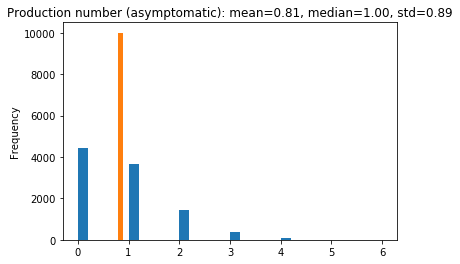

In [36]:
import os

model.params.set('prop_asym_carriers', 'loc', 1.0)
model.params.set('prop_asym_carriers', 'scale', 0)

infections = []
r0 = []
with open(os.devnull, 'w') as logger:
    logger.id = 1
    model.draw_prop_asym_carriers()
    model.params.set('asymptomatic_r0', 'low', 0.8)
    model.params.set('asymptomatic_r0', 'high', 0.8)    
    for i in range(10000):
        ind = Individual(id='0', susceptibility=1, model=model, logger=logger)
        evts = ind.asymptomatic_infect(time=0, by=None,
                                     handle_symptomatic=['keep'])
        r0.append(ind.r0)
        # print(', '.join(x.action.name for x in evts))
        infect_evts = [evt for evt in evts if evt.action.name == 'INFECTION']
        infections.append(len(infect_evts))

ifn = pd.Series(infections)
ifn.plot.hist( bins=30,
         title=f'Production number (asymptomatic): mean={ifn.mean():.2f}, median={ifn.median():.2f}, std={ifn.std():.2f}')

asr0 = pd.Series(r0)
asr0.plot.hist()


## Transmissibility curve



['piecewise', 0.2, 0.4, 5.0, 7.0]
['piecewise', 0.2, 0.4, 5.0, 7.0]
['piecewise', 0.2, 0.4, 5.0, 7.0]
['piecewise', 0.2, 0.4, 5.0, 7.0]
['piecewise', 0.2, 0.4, 5.0, 7.0]


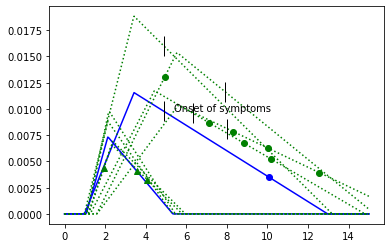

In [19]:
import os
import matplotlib.pyplot as plt

model.params.set('prop_asym_carriers', 'loc', 0)
model.params.set('prop_asym_carriers', 'scale', 0)

infections = []
r0 = []

with open(os.devnull, 'w') as logger:
    logger.id = 1
    model.draw_prop_asym_carriers()
    for i in range(5):
        ind = Individual(id='0', susceptibility=1, model=model, logger=logger)
        evts = ind.symptomatic_infect(time=0, by=None,
                                     handle_symptomatic=['keep'])
        x = np.linspace(0, 15, 15*24)
        #y = [ind.viral_load(t) for t in x]
        #plt.plot(x,y, linestyle=':' if i > 0 else '-', color='red')
        #
        y = [ind.transmissibility(t) for t in x]
        plt.plot(x,y, linestyle=':' if i > 0 else '-', color='blue' if i == 0 else 'green' )

        # incubation
        plt.plot(ind.incubation_period, ind.transmissibility(ind.incubation_period),
                color='black', markersize=20, marker='|')
        if i == 0:
            plt.text( ind.incubation_period + 0.5, ind.transmissibility(ind.incubation_period),
                    'Onset of symptoms')        
        # infection event
        it = [x.time for x in evts if x.action.name == 'INFECTION']
        ity = [ind.transmissibility(t) for t in it]
        plt.plot(it, ity, 'bo' if i == 0 else 'go')
        
model.params.set('prop_asym_carriers', 'loc', 1)
model.params.set('prop_asym_carriers', 'scale', 0)

infections = []
r0 = []

with open(os.devnull, 'w') as logger:
    logger.id = 1
    model.draw_prop_asym_carriers()
    for i in range(5):
        ind = Individual(id='0', susceptibility=1, model=model, logger=logger)
        evts = ind.asymptomatic_infect(time=0, by=None,
                                     handle_symptomatic=['keep'])
        x = np.linspace(0, 15, 15*24)
        y = [ind.transmissibility(t) for t in x]
        plt.plot(x,y, linestyle=':' if i > 0 else '-', color='blue' if i == 0 else 'green' )
        
        #
        it = [x.time for x in evts if x.action.name == 'INFECTION']
        ity = [ind.transmissibility(t) for t in it]
        plt.plot(it, ity, 'g^' if i == 0 else 'g^')
        
plt.show()
                

## Test sensibility



In [9]:
from covid19_outbreak_simulator.cli import main

main('''--popsize 100000 --rep 1
    --symptomatic-transmissibility-model piecewise 0.2 0.7 7 9 
    --asymptomatic-transmissibility-model piecewise 0.2 0.4 5 7
    --stop-if t>14   --track-events PLUGIN END   
    --logfile test.log   --plugin init --incidence-rate 1   
    --plugin quarantine --at 0 --duration 14 --target all --proportion 1   
    --plugin testing   --interval 1 --proportion 1
    --turnaround-time 0
    --handle-positive keep --sensitivity 0.85 0.0002  --specificity 1
  '''.split())

100%|##########| 1/1 [47:57<00:00, 2877.13s/it]


logfile	test.log
popsize	100000
handle_symptomatic	remove 1
interval	1 hour
prop_asym_carriers	10% to 40%
leadtime	no
n_simulation	1
total_infection	0
total_infection_failed	0
total_infection_avoided	0
total_infection_ignored	0
total_show_symptom	0
total_removal	0
total_recover	0
total_quarantine	0
total_reintegration	0
total_abort	0
total_asym_infection	0
total_presym_infection	0
total_sym_infection	0
n_remaining_popsize_21096	1
n_no_outbreak	0
n_outbreak_duration_16	1
n_no_infected_by_seed	1
n_seed_show_no_symptom	1
n_no_first_infection	1
n_first_symptom	0
n_second_symptom	0
n_third_symptom	0
plugin_name_0.00	init, testing
plugin_name_1.00	testing
plugin_name_2.00	testing
plugin_name_3.00	testing
plugin_name_4.00	testing
plugin_name_5.00	testing
plugin_name_6.00	testing
plugin_name_7.00	testing
plugin_name_8.00	testing
plugin_name_9.00	testing
plugin_name_10.00	testing
plugin_name_11.00	testing
plugin_name_12.00	testing
plugin_name_13.00	testing
plugin_name_14.00	testing
plugin_n_rec

0

In [8]:
res = pd.read_csv('test.log', sep='\t')
res = res[(res['event'] == 'PLUGIN') & res['params'].str.startswith('name=testing')]

In [7]:
res

,id,time,event,target,params
2,1,0.0,PLUGIN,.,"name=testing,n_tesetd=100000,n_detected=0,n_fa..."
